✅ Transform pipelines created.
✅ Training samples: 8, Validation samples: 8
Classes: ['class_0_non_agri', 'class_1_agri']
✅ CNN model initialized.


Epoch 1/5 | Train Loss: 0.691, Train Acc: 0.62 | Val Loss: 0.669, Val Acc: 0.50


Epoch 2/5 | Train Loss: 0.722, Train Acc: 0.25 | Val Loss: 0.659, Val Acc: 0.62


Epoch 3/5 | Train Loss: 0.653, Train Acc: 0.62 | Val Loss: 0.610, Val Acc: 0.75


Epoch 4/5 | Train Loss: 0.641, Train Acc: 0.75 | Val Loss: 0.533, Val Acc: 0.75


Epoch 5/5 | Train Loss: 0.504, Train Acc: 0.88 | Val Loss: 0.464, Val Acc: 0.88
✅ Training complete.


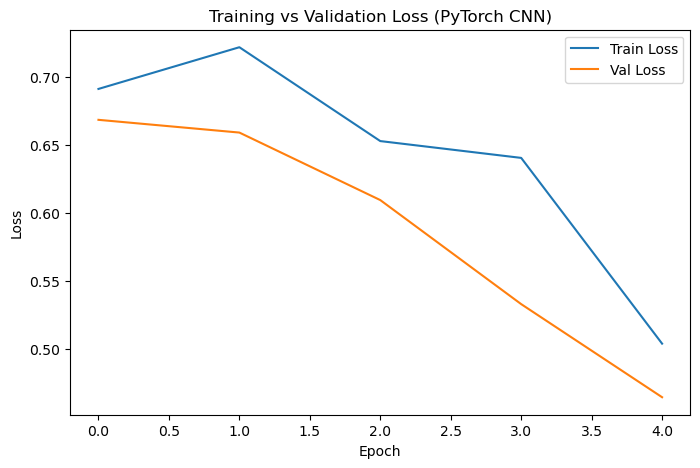

✅ Retrieved all predictions and labels from validation set.
Predictions: [1, 0, 0, 0, 1, 1, 1, 1]
Ground Truth: [0, 0, 0, 0, 1, 1, 1, 1]


In [1]:
# =============================================
# QUESTION 5 — IMPLEMENT AND TEST A PYTORCH-BASED CLASSIFIER
# =============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# TASK 1: Explain usefulness of random initialization
# ------------------------------------------------------------
# Random initialization ensures that each neuron starts with different weights,
# breaking symmetry so neurons can learn unique features instead of updating identically.

# ------------------------------------------------------------
# TASK 2 & 3: Define train_transform and val_transform pipelines
# ------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

print("✅ Transform pipelines created.")

# ------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------
dataset_path = '../images_dataSAT'   # adjust if notebook at project root

train_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=dataset_path, transform=val_transform)

# TASK 4: Create val_loader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"✅ Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print("Classes:", train_dataset.classes)

# ------------------------------------------------------------
# Define a simple CNN model
# ------------------------------------------------------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 128), nn.ReLU(),
            nn.Linear(128, 2)   # two classes
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
print("✅ CNN model initialized.")

# ------------------------------------------------------------
# Optimizer, Loss
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------------------------------------------
# TASK 5: Purpose of tqdm
# ------------------------------------------------------------
# tqdm creates progress bars for loops to visually track training progress.

# ------------------------------------------------------------
# Training Loop
# ------------------------------------------------------------
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # TASK 6: Reset counters every epoch
    # train_loss, train_correct, and train_total are reset each epoch
    # so that metrics reflect performance for that epoch only.
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = train_correct / train_total
    train_losses.append(epoch_loss)

    # --------------------------------------------------------
    # Validation
    # --------------------------------------------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    # TASK 7: Why use torch.no_grad()
    # torch.no_grad() disables gradient calculation, saving memory and computation
    # during evaluation since we do not need backpropagation.
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.2f} | "
          f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}")

print("✅ Training complete.")

# ------------------------------------------------------------
# TASK 8: Metrics used to evaluate training performance
# ------------------------------------------------------------
# Common metrics include:
# 1. Accuracy  — proportion of correct predictions
# 2. F1-score  — harmonic mean of precision and recall (especially for imbalance)

# ------------------------------------------------------------
# TASK 9: Plot model training loss
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss (PyTorch CNN)')
plt.show()

# ------------------------------------------------------------
# TASK 10: Retrieve predictions and ground truth from val_loader
# ------------------------------------------------------------
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.numpy().tolist())

print("✅ Retrieved all predictions and labels from validation set.")
print("Predictions:", all_preds)
print("Ground Truth:", all_labels)
